In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from pandas.errors import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)


In [2]:
# ==========================================
# 1. Configuration & Data Loading
# ==========================================


# Load data
print("Loading data...")
df_train = pd.read_csv('train.csv', index_col='index')
df_test_base = pd.read_csv('test.csv')


print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test_base.shape}")

# Merge for consistent feature engineering
df_train['is_train'] = 1
df_test_base['is_train'] = 0
df_test_base['y'] = np.nan

# align columns (ensure test has same columns as train except 'y')
df = pd.concat([df_train, df_test_base], sort=False).reset_index(drop=True)

Loading data...
Train shape: (391650, 17)
Test shape: (262605, 16)


In [41]:
df_train

,id,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,is_train
index,,,,,,,,,,,,,,,,,,
70,1705.0;13221.0;1.0,1705,13221,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,1
71,1705.0;13221.0;2.0,1705,13221,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,1
72,1705.0;13221.0;3.0,1705,13221,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,1
73,1705.0;13221.0;4.0,1705,13221,4,0.0,0.0,0.0,0.0,0.000001,0.000005,0.000016,0.000008,4.501503e-07,0.0,0.000003,0.000094,1.0,1
74,1705.0;13221.0;5.0,1705,13221,5,0.0,0.0,0.0,0.0,0.000003,0.000005,0.000047,0.000025,4.051353e-06,0.0,0.000003,0.000071,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654215,697.0;17221.0;31.0,697,17221,31,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,1
654216,697.0;17221.0;32.0,697,17221,32,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,1
654217,697.0;17221.0;33.0,697,17221,33,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,1


In [42]:
df_train.describe()

,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,is_train
count,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,3.916500e+05,391650.000000,391650.000000,391650.000000,391650.000000,391650.0
mean,947.069526,9454.379893,18.000000,0.046393,0.000313,0.000605,0.001052,0.001322,0.001598,0.001494,0.001608,9.665011e-04,0.001083,0.002054,0.001712,0.718861,1.0
std,500.262220,5366.549883,10.099518,0.210336,0.008093,0.008962,0.007231,0.012258,0.013716,0.011622,0.012318,8.540218e-03,0.007732,0.016153,0.013391,0.449556,0.0
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.0
25%,562.000000,4909.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.0
50%,970.000000,9320.500000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000007,0.000012,0.000000,0.000008,9.003007e-07,0.000000,0.000019,0.000071,1.000000,1.0
75%,1372.000000,14102.000000,27.000000,0.000000,0.000020,0.000017,0.000155,0.000123,0.000185,0.000156,0.000172,8.507841e-05,0.000143,0.000244,0.000424,1.000000,1.0
max,1822.000000,18692.000000,35.000000,1.000000,1.000000,1.000000,0.894957,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.743992,1.000000,1.000000,1.000000,1.0


In [43]:
pd.crosstab(df_train["x12"] > 0, df_train["y"], normalize="index")

y,0.0,1.0
x12,,
False,1.000000,0.000000
True,0.935463,0.064537


In [42]:
train_g1 = set(df_train["g1"].unique())
test_g1 = set(df_test_base["g1"].unique())

missing_g1 = test_g1 - train_g1
len(missing_g1)

730

In [43]:
train_g2 = set(df_train["g2"].unique())
test_g2 = set(df_test_base["g2"].unique())

missing_g2 = test_g2 - train_g2
len(missing_g2)

7503

In [44]:
(df_train["y"] == 0).sum() / len(df_train)

np.float64(0.9536065364483595)

# Вывод: 
Получили по данным
- id уникальный номер (сублимация g1,g2,relative_date_number) - дропаем при обучении
- g1/g2 каталожные номера. g2 очевидно или название товара или подкаталог. Годятся только для группировки для feature engineering. На обучении тоже дропаем
- x1-12 фичи- берем все. Они сильно разрежены, кроме x12.
- relative_date_number -дата. Тут ясности нет. Но это не календарные даты, скорее относительные отрезки времени. На обоучении будем использовать не как время, а как каталожный параметр.
- Целевое значение - очень дисбалансно - 0.95 для y=0.

В качестве feature engineering: сделаем лаги и разность, скользящее среднее, EWM, куммулятивные суммы. Попробуем сделать небольшой временной параметр по relative_date_number
Из-за дисбаланса целевого, буем пользовать довольно сильной глубиной  приобучении модели. И возможно потребуется поборка порога для предикта.

In [3]:
# ==========================================
# FEATURE ENGINEERING
# ==========================================

x_cols = [f'x{i}' for i in range(1, 13)]

# -----------------------------
# 1. Lag и Diff внутри групп
# -----------------------------
lag_list = [1,2,3]
diff_list = [1,2]

for c in x_cols:
    for l in lag_list:
        df[f'{c}_lag{l}'] = df.groupby(['g1','g2'])[c].shift(l)
    for l in diff_list:
        df[f'{c}_diff{l}'] = df[c] - df.groupby(['g1','g2'])[c].shift(l)

# -----------------------------
# 2. Rolling Mean & Std
# -----------------------------
windows = [3,5,7]

for c in x_cols:
    for w in windows:
        grp = df.groupby(['g1','g2'])[c]
        df[f'{c}_roll_mean_{w}'] = grp.shift(1).rolling(w, min_periods=1).mean()
        df[f'{c}_roll_std_{w}']  = grp.shift(1).rolling(w, min_periods=1).std().fillna(0)

# -----------------------------
# 3. Exponential Weighted Mean (EWM)
# -----------------------------
alphas = [0.3, 0.5, 0.7]
for c in x_cols:
    for alpha in alphas:
        grp = df.groupby(['g1','g2'])[c]
        ewm_col = grp.shift(1).ewm(alpha=alpha).mean()
        df[f'{c}_ewm_{int(alpha*10)}'] = ewm_col
        df[f'{c}_ewm_diff_{int(alpha*10)}'] = df[c] - ewm_col

# -----------------------------
# 4. Cumulative Sum & Cumulative Mean Diff
# -----------------------------
for c in x_cols:
    grp = df.groupby(['g1','g2'])[c]
    cumsum = grp.cumsum()
    count = grp.cumcount() + 1
    df[f'{c}_cumsum'] = cumsum
    df[f'{c}_cummean_diff'] = df[c] - (cumsum / count)

# -----------------------------
# 5. Row-level aggregates
# -----------------------------
df['x_mean']  = df[x_cols].mean(axis=1)
df['x_std']   = df[x_cols].std(axis=1)
df['x_min']   = df[x_cols].min(axis=1)
df['x_max']   = df[x_cols].max(axis=1)
df['x_range'] = df['x_max'] - df['x_min']
df['x_cv']    = df['x_std'] / (df['x_mean'] + 1e-6)

# -----------------------------
# 6. Row fractions (x_i / sum)
# -----------------------------
row_sum = df[x_cols].sum(axis=1) + 1e-6
for c in x_cols:
    df[f'{c}_row_frac'] = df[c] / row_sum

# -----------------------------
# 7. Dominance (argmax/argmin)
# -----------------------------
df['x_argmax'] = df[x_cols].values.argmax(axis=1)
df['x_argmin'] = df[x_cols].values.argmin(axis=1)

# -----------------------------
# 8. Time cycles
# -----------------------------
df['day_cycle']   = df['relative_date_number'] % 7



In [4]:
df

,id,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,...,x6_row_frac,x7_row_frac,x8_row_frac,x9_row_frac,x10_row_frac,x11_row_frac,x12_row_frac,x_argmax,x_argmin,day_cycle
0,1705.0;13221.0;1.0,1705,13221,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0,0,1
1,1705.0;13221.0;2.0,1705,13221,2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0,0,2
2,1705.0;13221.0;3.0,1705,13221,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0,0,3
3,1705.0;13221.0;4.0,1705,13221,4,0.0,0.000000,0.000000,0.000000,0.000001,0.000005,...,0.000016,0.000008,4.500927e-07,0.000000,0.000003,0.000094,0.999872,11,0,4
4,1705.0;13221.0;5.0,1705,13221,5,0.0,0.000000,0.000000,0.000000,0.000003,0.000005,...,0.000047,0.000025,4.050717e-06,0.000000,0.000003,0.000071,0.999843,11,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654250,1145.0;8996.0;31.0,1145,8996,31,NaN,0.000073,0.000027,0.000557,0.000325,0.000358,...,0.000590,0.000792,9.737630e-04,0.000711,0.000769,0.000258,0.994572,11,1,3
654251,1145.0;8996.0;32.0,1145,8996,32,NaN,0.000082,0.000027,0.000557,0.000320,0.000346,...,0.000823,0.000988,1.406124e-03,0.000455,0.000872,0.000281,0.993852,11,1,4
654252,1145.0;8996.0;33.0,1145,8996,33,NaN,0.000033,0.000010,0.000248,0.000302,0.000332,...,0.000916,0.000735,1.905252e-03,0.000256,0.000864,0.000398,0.994006,11,1,5
654253,1145.0;8996.0;34.0,1145,8996,34,NaN,0.000073,0.000026,0.000557,0.000412,0.000448,...,0.000899,0.001166,1.705406e-03,0.000483,0.001042,0.000397,0.992800,11,1,6


In [4]:
# 3. Preparation for Training
# ==========================================
# Split back into Train and Test
train_df = df[df['is_train'] == 1].copy()
test_df = df[df['is_train'] == 0].copy()

drop_cols = ['id', 'y', 'is_train', 'g1', 'g2']
features = [c for c in train_df.columns if c not in drop_cols]

X = train_df[features]
y = train_df['y']

X_test = test_df[features]

# -----------------------------
# Manual time-based split with fixed-size blocks
# -----------------------------
cycle_len = 35         # дней
num_tovar = 514        # товаров в блоке
block_size = cycle_len * num_tovar  # 17990 строк

total_rows = train_df.shape[0]

# Стартовые позиции для поиска блока (30% и 60%)
block_starts = [int(0.3*total_rows), int(0.6*total_rows)]

# Массив всех индексов
all_idx = train_df.index.values
# Массив всех дат
all_dates = train_df['relative_date_number'].values

date1_idx = all_idx[all_dates == 1]

val_indices = []

for start_pos in block_starts:
    # Находим ближайший индекс в date1_idx >= start_pos
    rel_idx = np.searchsorted(date1_idx, all_idx[start_pos])
    if rel_idx >= len(date1_idx):
        raise ValueError(f"No date=1 found after position {start_pos}")

    idx_start = date1_idx[rel_idx]

    # Конец блока
    idx_end = idx_start + block_size
    if idx_end > total_rows:
        idx_end = total_rows

    val_indices.extend(all_idx[idx_start:idx_end])

# Маска для валидации
val_mask = train_df.index.isin(val_indices)

# Разбиваем
X_train = X[~val_mask]
y_train = y[~val_mask]

X_val = X[val_mask]
y_val = y[val_mask]

print(f"Train: {X_train.shape}, Val: {X_val.shape}")
print(f"y=1 proportion: Train={y_train.mean():.4f}, Val={y_val.mean():.4f}")

Train: (355670, 262), Val: (35980, 262)
y=1 proportion: Train=0.0459, Val=0.0517


In [5]:
# Обучение CatBoost на time-split
# ------------------------------------------
model = CatBoostClassifier(
    iterations=20000,
    learning_rate=0.02,
    depth=8,
    l2_leaf_reg=5,
    loss_function='Logloss',
    eval_metric='F1',          # целевой показатель
    random_seed=42,
    verbose=100,
    task_type="GPU",
    allow_writing_files=False
)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=300
)

# Предсказания на валидацию и тест
val_probs = model.predict_proba(X_val)[:, 1]




0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 139ms	remaining: 46m 25s
100:	learn: 0.0069635	test: 0.0053591	best: 0.0053591 (100)	total: 1.94s	remaining: 6m 21s
200:	learn: 0.0483005	test: 0.0779887	best: 0.0779887 (200)	total: 3.79s	remaining: 6m 13s
300:	learn: 0.0904862	test: 0.1226321	best: 0.1226321 (298)	total: 5.66s	remaining: 6m 10s
400:	learn: 0.1220250	test: 0.1521951	best: 0.1521951 (397)	total: 7.28s	remaining: 5m 55s
500:	learn: 0.1413424	test: 0.1721154	best: 0.1721154 (498)	total: 8.9s	remaining: 5m 46s
600:	learn: 0.1637284	test: 0.1870845	best: 0.1878558 (598)	total: 10.8s	remaining: 5m 47s
700:	learn: 0.1768925	test: 0.2013170	best: 0.2013170 (695)	total: 12.6s	remaining: 5m 47s
800:	learn: 0.1894645	test: 0.2052484	best: 0.2052484 (774)	total: 14.5s	remaining: 5m 47s
900:	learn: 0.2026829	test: 0.2098881	best: 0.2098881 (898)	total: 16.2s	remaining: 5m 43s
1000:	learn: 0.2148208	test: 0.2164422	best: 0.2165428 (981)	total: 17.9s	remaining: 5m 39s
11

In [6]:
model.save_model("catboost_base2.cbm")


# model_catboost = CatBoostClassifier()
# model_catboost.load_model("catboost_base.cbm")

In [6]:
# Подбор оптимального порога на валидации
thr_scan = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_val, (val_probs >= t).astype(int)) for t in thr_scan]
best_thresh = thr_scan[np.argmax(f1_scores)]
print(f"\nBest Threshold (time-split): {best_thresh:.2f}")

# Binarize predictions
val_preds = (val_probs >= best_thresh).astype(int)

print(f"Validation F1: {f1_score(y_val, val_preds):.4f}")



Best Threshold (time-split): 0.20
Validation F1: 0.4544


# Вывод:
Значение базово формируется по валидационной выборке. Но это очнеь приблизительные показатели, так как валидационная выборка не совпадает с тестовой.

In [7]:
test_probs = model.predict_proba(X_test)[:, 1]
test_preds = (test_probs >= best_thresh).astype(int)

# Распределение y=1 в тесте (просто для проверки)
print(f"Test set: total rows = {len(test_preds)}")
print(f"Predicted y=1 count = {test_preds.sum()}")
print(f"Predicted y=1 proportion = {test_preds.mean():.4f}")

Test set: total rows = 262605
Predicted y=1 count = 13031
Predicted y=1 proportion = 0.0496


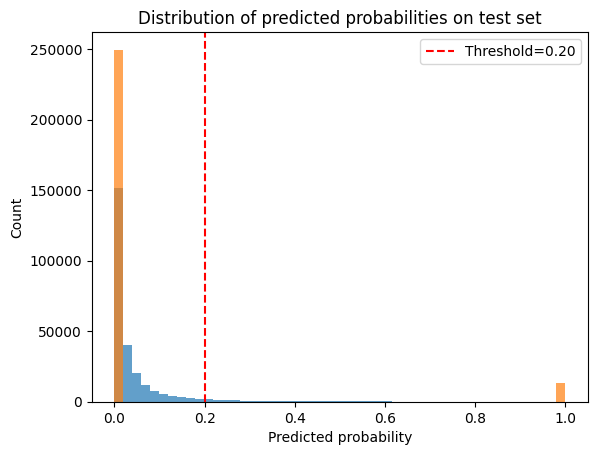

In [8]:
plt.hist(test_probs, bins=50, alpha=0.7)
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Threshold={best_thresh:.2f}')
plt.title('Distribution of predicted probabilities on test set')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.legend()
plt.savefig('test_prob_hist.png')
plt.hist(test_preds, bins=50, alpha=0.7)
plt.show()

In [9]:
submission = pd.DataFrame({
    'id': df_test_base['id'],
    'y': test_preds
})

# Сохраняем в CSV
submission.to_csv('submission_time3.csv', index=False)

print(f"Submission saved! Total rows = {len(submission)}, Predicted y=1 = {test_preds.sum()}, proportion = {test_preds.mean():.4f}")

Submission saved! Total rows = 262605, Predicted y=1 = 13031, proportion = 0.0496


In [10]:
p_val = y_val.mean()
total_test = len(test_probs)
target_ones = int(p_val * total_test)

# ---------------------------------------------
# 2. Вычисляем порог, чтобы получить примерно target_ones единиц
# ---------------------------------------------
sorted_probs = np.sort(test_probs)[::-1]  # сортируем по убыванию
adjusted_thresh = sorted_probs[target_ones-1]  # вероятность на позиции target_ones

# ---------------------------------------------
# 3. Бинаризация с новым порогом
# ---------------------------------------------
test_preds_adjusted = (test_probs >= adjusted_thresh).astype(int)

# ---------------------------------------------
# 4. Проверка
# ---------------------------------------------
print(f"Adjusted threshold: {adjusted_thresh:.4f}")
print(f"Predicted y=1 count: {test_preds_adjusted.sum()}")
print(f"Predicted y=1 proportion: {test_preds_adjusted.mean():.4f}")

# ---------------------------------------------
# 5. Генерация сабмита
# ---------------------------------------------
submission = pd.DataFrame({
    'id': df_test_base['id'],  # используем базовый тест для корректного id
    'y': test_preds_adjusted
})



submission.head()

Adjusted threshold: 0.1939
Predicted y=1 count: 13575
Predicted y=1 proportion: 0.0517


,id,y
0,1757.0;16543.0;1.0,0
1,1757.0;16543.0;2.0,0
2,1757.0;16543.0;3.0,0
3,1757.0;16543.0;4.0,0
4,1757.0;16543.0;5.0,0


In [11]:
imp = pd.Series(model.get_feature_importance(), index=features).sort_values(ascending=False)
print("\nTop 20 feature_importance")
print(imp.head(20))



Top 20 feature_importance
relative_date_number    9.543884
x12                     7.301720
x_mean                  4.275633
x_max                   3.647915
x_cv                    3.212099
x11                     2.445517
x12_ewm_diff_5          2.334802
x12_row_frac            2.246608
day_cycle               1.846376
x12_cumsum              1.487506
x10_cummean_diff        1.442732
x10_cumsum              1.260751
x12_cummean_diff        1.254711
x12_ewm_diff_3          1.168745
x_argmax                1.131489
x10_roll_std_3          1.104428
x2_roll_std_7           1.022656
x2_roll_std_5           0.986773
x10_diff2               0.946632
x6_roll_mean_7          0.930799
dtype: float64


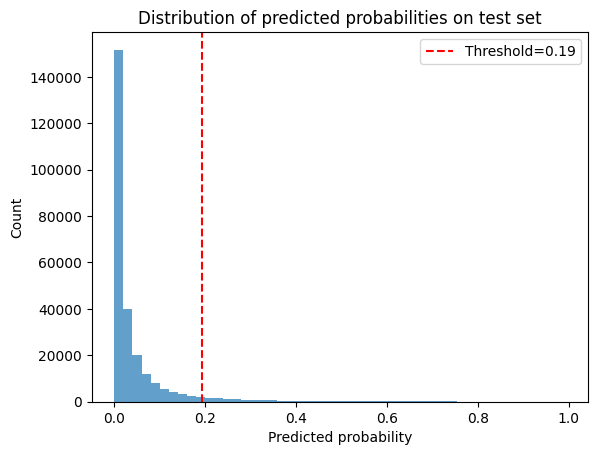

In [12]:
plt.hist(test_probs, bins=50, alpha=0.7)
plt.axvline(adjusted_thresh, color='red', linestyle='--', label=f'Threshold={adjusted_thresh:.2f}')
plt.title('Distribution of predicted probabilities on test set')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.legend()
plt.savefig('test_prob_hist3.png')
plt.show()

In [33]:
np.percentile(test_probs, [94, 93.5, 93, 92.5])

array([0.11575714, 0.10562514, 0.09665681, 0.08910553])

In [15]:
submission = pd.DataFrame({
    'id': df_test_base['id'],
    'y': test_preds_adjusted
})

submission.to_csv('submission_adjusted.csv', index=False)

# Попробуем на основании графика немного сместить Threshold

In [13]:
target_share = 0.055  # как на val
new_thr = np.quantile(test_probs, 1 - target_share)

In [14]:
new_thr

np.float64(0.18547623736806546)

In [15]:
test_preds_share = (test_probs >= new_thr).astype(int)

# ---------------------------------------------
# 4. Проверка
# ---------------------------------------------
print(f"Adjusted threshold: {new_thr:.4f}")
print(f"Predicted y=1 count: {test_preds_share.sum()}")
print(f"Predicted y=1 proportion: {test_preds_share.mean():.4f}")

# ---------------------------------------------
# 5. Генерация сабмита
# ---------------------------------------------
submission = pd.DataFrame({
    'id': df_test_base['id'],  # используем базовый тест для корректного id
    'y': test_preds_share
})

submission.to_csv('submission_adjusted_share.csv', index=False)



Adjusted threshold: 0.1855
Predicted y=1 count: 14444
Predicted y=1 proportion: 0.0550


In [47]:
target_share = 0.060
new_thr = np.quantile(test_probs, 1 - target_share)
new_thr

np.float64(0.17411213847310442)

In [48]:
test_preds_share = (test_probs >= new_thr).astype(int)

# ---------------------------------------------
# 4. Проверка
# ---------------------------------------------
print(f"Adjusted threshold: {new_thr:.4f}")
print(f"Predicted y=1 count: {test_preds_share.sum()}")
print(f"Predicted y=1 proportion: {test_preds_share.mean():.4f}")

Adjusted threshold: 0.1741
Predicted y=1 count: 15757
Predicted y=1 proportion: 0.0600


In [41]:
submission = pd.DataFrame({
    'id': df_test_base['id'],
    'y': test_preds_share
})

submission.to_csv('submission_605.csv', index=False)

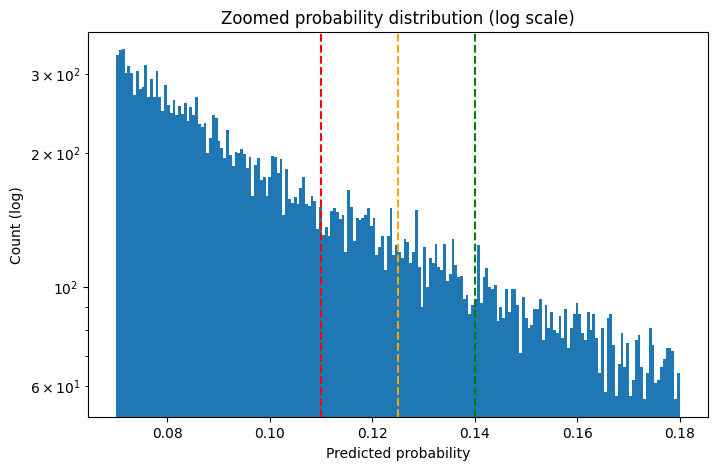

In [18]:
low, high = 0.07, 0.18  # именно здесь живёт магия

mask = (test_probs >= low) & (test_probs <= high)
zoom_probs = test_probs[mask]

plt.figure(figsize=(8,5))
plt.hist(zoom_probs, bins=200)
plt.yscale("log")
plt.axvline(0.11, color="red", linestyle="--")
plt.axvline(0.125, color="orange", linestyle="--")
plt.axvline(0.14, color="green", linestyle="--")
plt.title("Zoomed probability distribution (log scale)")
plt.xlabel("Predicted probability")
plt.ylabel("Count (log)")
plt.savefig('Zoomed probability distribution.png')
plt.show()

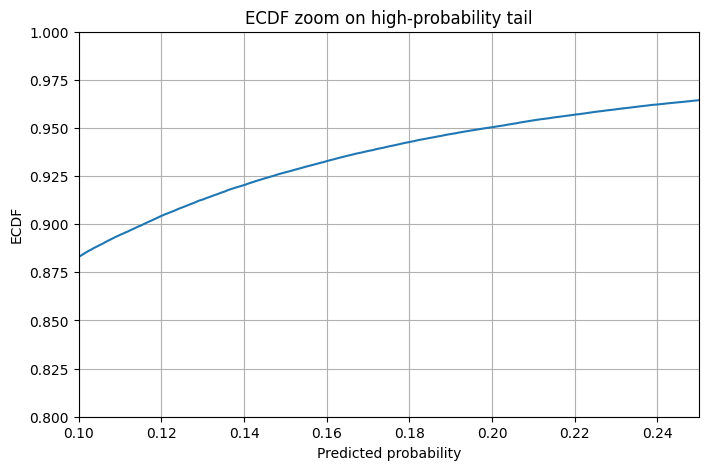

In [20]:
sorted_probs = np.sort(test_probs)
ecdf = np.arange(1, len(sorted_probs)+1) / len(sorted_probs)

plt.figure(figsize=(8,5))
plt.plot(sorted_probs, ecdf)
plt.xlim(0.10, 0.25)
plt.ylim(0.80, 1.0)
plt.grid(True)
plt.xlabel("Predicted probability")
plt.ylabel("ECDF")
plt.title("ECDF zoom on high-probability tail")
plt.savefig('ECDF zoom.png')
plt.show()

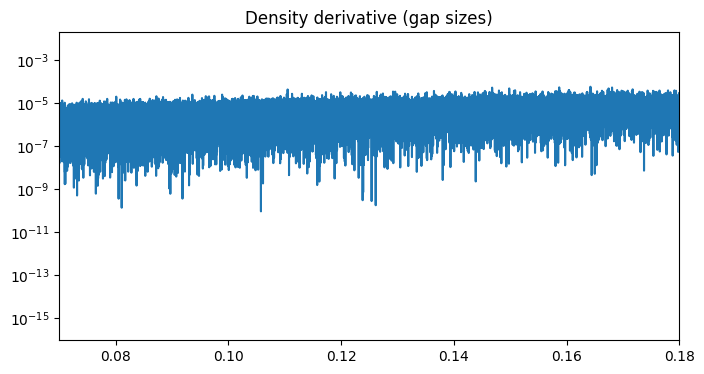

In [21]:
dens = np.diff(sorted_probs)

plt.figure(figsize=(8,4))
plt.plot(sorted_probs[:-1], dens)
plt.xlim(0.07, 0.18)
plt.yscale("log")
plt.title("Density derivative (gap sizes)")
plt.savefig('Density derivative .png')
plt.show()